# Setup

In [1]:
# Imports

import cv2
import keras
import numpy as np
from scipy import sparse
import pandas as pd
import networkx as nx
from networkx_viewer import Viewer
from sklearn.feature_extraction import image
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Conv2D, recurrent

Using TensorFlow backend.


# Image to graph

In [149]:
def _make_edges_3d(n_x, n_y, n_z=1):
    """Returns a list of edges for a 3D image.
    Parameters
    ===========
    n_x: integer
        The size of the grid in the x direction.
    n_y: integer
        The size of the grid in the y direction.
    n_z: integer, optional
        The size of the grid in the z direction, defaults to 1
    """
    vertices = np.arange(n_x * n_y * n_z).reshape((n_x, n_y, n_z))
    edges_deep = np.vstack((vertices[:, :, :-1].ravel(),
                            vertices[:, :, 1:].ravel()))
    edges_right = np.vstack((vertices[:, :-1].ravel(),
                             vertices[:, 1:].ravel()))
    edges_down = np.vstack((vertices[:-1].ravel(), vertices[1:].ravel()))
    edges = np.hstack((edges_deep, edges_right, edges_down))
    return edges

In [150]:
def _compute_altitude_3d(edges, img):
    n_x, n_y, n_z = img.shape
    gradient = np.abs(img[edges[0] // (n_y * n_z),
                          (edges[0] % (n_y * n_z)) // n_z,
                          (edges[0] % (n_y * n_z)) % n_z] -
                          img[edges[1] // (n_y * n_z),
                          (edges[1] % (n_y * n_z)) // n_z,
                          (edges[1] % (n_y * n_z)) % n_z])
    return gradient

In [151]:
def img_to_graph(image):
    
    dtype=None
    image = np.atleast_3d(image)
    n_x, n_y, n_z = image.shape
    edges = _make_edges_3d(n_x, n_y, n_z)
    weights = _compute_altitude_3d(edges, image)
    diag = image.ravel()
    n_voxels = diag.size
    diag_idx = np.arange(n_voxels)
    i_idx = np.hstack((edges[0], edges[1]))
    j_idx = np.hstack((edges[1], edges[0]))
    matrix = sparse.coo_matrix((np.hstack((weights, weights, diag)),
                              (np.hstack((i_idx, diag_idx)),
                               np.hstack((j_idx, diag_idx)))),
                              (n_voxels, n_voxels),
                              dtype=dtype)
    graph = nx.from_scipy_sparse_matrix(matrix)
    graph.remove_edges_from(graph.selfloop_edges())
    
    mapping = map_node(image)
    values = get_altitude_map(image)
    
    graph = nx.relabel_nodes(graph, mapping)
    nx.set_node_attributes(graph,'value',values=values)
    
    
    return graph

In [178]:
def get_altitude_map(img):
    values = dict()
    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            values[(row,col)] = img[row,col][0]
    
    return values

In [179]:
def map_node(img):
    
    assert isinstance(a, np.ndarray), "Not an image"
    
    mapping = dict()
    
    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            mapping[row * img.shape[1] + col] = ((row), (col))

    return mapping

In [193]:
def view_graph(img, graph, pixel_values=False):
    
    positions = dict()
    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            positions[(row,col)] = ((col), (img.shape[1]-row))
          
    pos = nx.spring_layout(graph,pos=positions, fixed = graph.nodes())
    labels = nx.get_edge_attributes(graph,'weight')
    
    if pixel_values:
        values = nx.get_node_attributes(graph,'value')
        nx.draw(graph,pos,labels=values)
    else:
        nx.draw(graph,pos)
        nx.draw_networkx_labels(graph,pos)
        
    edge_labels = nx.draw_networkx_edge_labels(graph,pos,edge_labels=labels)

In [195]:
# Set image size
img_resize=(5,5,1)

#import Images
img = cv2.imread('1O.jpg', 0)
gt = cv2.imread('1G.jpg', 0)
img = img[0:img_resize[0], 0:img_resize[1]]
gt = gt[0:img_resize[0], 0:img_resize[1]]
img = img.astype(np.int16)
gt = gt.astype(np.int16)

#Translate image to 4 connected grid graph
image_graph = img_to_graph(img)
ground_truth_graph = img_to_graph(gt)

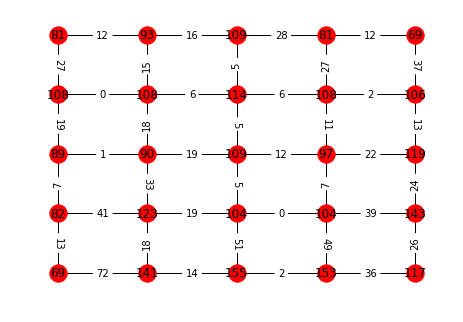

In [198]:
view_graph(img, image_graph,pixel_values=True)

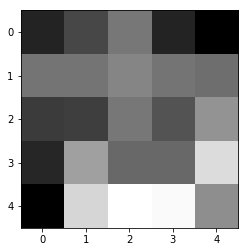

In [204]:
plt.imshow(img, cmap = 'gray')

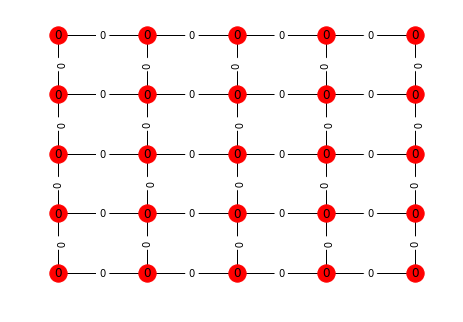

In [197]:
view_graph(gt, ground_truth_graph,pixel_values=True)

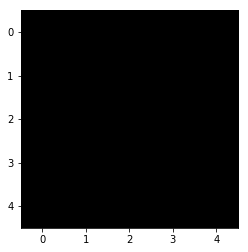

In [203]:
plt.imshow(gt, cmap = 'gray')

In [232]:
len(nx.get_edge_attributes(graph,'weight').values())

126504

In [233]:
def get_boundary_probabilities(img):
    
    #Make a placeholder for boundary probabilities coming in next iteration of pipeline
    return np.random.rand(img_resize[0],img_resize[1])

In [234]:
I_a.shape

(252, 252, 2)

In [236]:
I = img
print I.shape
boundary_probabilities = get_boundary_probabilities(I)

#Augment the image with boundary probabilities
I_a = np.dstack((I, boundary_probabilities))

#Create Model
from keras.layers import Dense, Activation, Recurrent

from keras import optimizers

model = Sequential()
model.add(Conv2D(16, 5, input_shape=I_a.shape, activation='elu', dilation_rate=1))
model.add(Conv2D(16, 3, activation='elu', dilation_rate=1))
model.add(Conv2D(32, 3, activation='elu', dilation_rate=2))
model.add(Conv2D(32, 3, activation='elu', dilation_rate=4))
model.add(Conv2D(64, 3, activation='elu', dilation_rate=8))
model.add(Conv2D(64, 3, activation='elu', dilation_rate=16))
model.add(Conv2D(128, 3, activation='elu', dilation_rate=1))
model.add(Dense(1024))
model.add(Dense(1))
#model.add(Dense(len(nx.get_edge_attributes(graph,'weight').values())))


"""Training was performed by stochastic gradient descent (SGD) with mini-batch size 14,
learning rate 10−3
, and momentum 0.9. The network was trained for 60K iterations."""

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

#Compute Altitudes with current model parameters

#

I_a = np.expand_dims(I_a, axis=0)
p = model.predict(I_a)
print p.shape

(252, 252, 1)
(1, 184, 184, 1)


In [219]:
p[0,:,:,0]

array([[-0.36356637, -0.38028884, -0.31565717, ..., -0.16191852,
        -0.36426044, -0.32957712],
       [-0.33196166, -0.50350296, -0.28878713, ..., -0.56227231,
        -0.36117327, -0.29996049],
       [-0.49372977, -0.40250069, -0.27348992, ..., -0.28096771,
        -0.32239872, -0.21431977],
       ..., 
       [-0.44773769, -0.54297799, -0.48131537, ..., -0.36836463,
        -0.36758232, -0.52226734],
       [-0.36676663, -0.46444643, -0.46431983, ..., -0.1857065 ,
        -0.40571523, -0.43323743],
       [-0.57433718, -0.51221085, -0.47775197, ..., -0.31362647,
        -0.49286199, -0.40582812]], dtype=float32)

In [189]:
I_a.shape

(1, 100, 100, 2)

In [190]:
I_a[0,0,0,:]

array([ 88.       ,   0.3451981])

In [191]:
I[0,0,:]

array([88], dtype=int16)

(1, 96, 96, 16)

In [173]:
p[0,0,0,:]

array([ 3.12481308, -0.96227485,  3.49154544, -0.5382762 , -0.90918523,
        0.83449161, -0.70998693,  0.44036934,  4.46567249, -0.87546444,
       -0.68696773, -0.30691391, -0.93509239, -0.40531236, -0.99781704,
       -0.92181677,  1.3948611 , -0.45131719,  0.51080537, -0.97048539,
       -0.92896301, -0.58866966, -0.94019961, -0.55908251,  0.28576887,
        1.30408406,  2.69624209, -0.38842565, -0.74179465,  0.20478624,
       -0.12914276, -0.57746118,  0.5547787 , -0.86723721,  1.33187437,
        3.50594997, -0.97171158, -0.66117108, -0.43622577, -0.9886933 ,
        0.03607702,  1.29375291, -0.91160041, -0.58185279, -0.0543583 ,
        3.95769453, -0.81320632,  1.0388279 ,  1.440135  ,  0.65312982,
       -0.26819646, -0.97723758,  5.45371389,  0.955841  ,  1.72034955,
        1.29644966, -0.31166732, -0.65844572,  0.83943945, -0.46552575,
       -0.97724169, -0.99731779,  0.74880099,  0.33263487, -0.83384848,
       -0.24687743,  1.04738569, -0.93623757, -0.99571151,  2.03

In [138]:
p[0,0,1,:]

array([-0.18248022, -0.1272058 ,  0.01445921, ...,  0.01033194,
       -0.11372139, -0.1584323 ], dtype=float32)

In [53]:
V_ = 
print (nx.shortest_path(graph, 0, 24))
nx.minimum_edge_cut(graph, 8, 25)

[0, 1, 8, 9, 16, 17, 24]


{(18, 25), (24, 25), (26, 25), (32, 25)}

In [60]:
print nx.shortest_path_length(graph, 0 ,48, weight='weight')
print nx.shortest_path(graph, 0 ,48)

135
[0, 1, 8, 9, 16, 17, 24, 25, 32, 33, 40, 41, 48]


In [38]:
g = nx.prim_mst(graph)

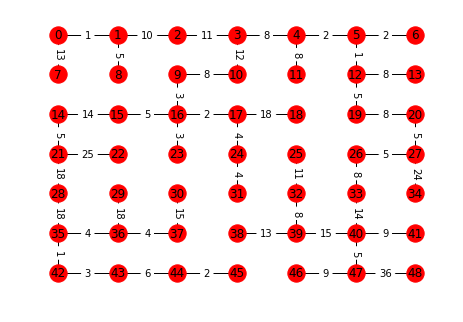

In [39]:
g[0][1]['weight'] = 1
fixed_nodes = positions.keys()
pos = nx.spring_layout(g,pos=positions, fixed = fixed_nodes)
labels = nx.get_edge_attributes(g,'weight')
nx.draw(g,pos)
nx.draw_networkx_labels(g,pos)
edge_labels = nx.draw_networkx_edge_labels(g,pos,edge_labels=labels)

In [24]:
g[0]

{1: {'weight': 1}, 10: {'weight': 13}}

# Boundary Probability

# Static Body Training

** - Loop this until convergence**

In [31]:
from keras.layers import Dense, Activation
model = Sequential()
model.add(Conv2D(16, 5, input_shape=img_resize, activation='elu', dilation_rate=1))
model.add(Conv2D(16, 3, activation='elu', dilation_rate=1))
model.add(Conv2D(32, 3, activation='elu', dilation_rate=2))
model.add(Conv2D(32, 3, activation='elu', dilation_rate=4))
model.add(Conv2D(64, 3, activation='elu', dilation_rate=8))
model.add(Conv2D(64, 3, activation='elu', dilation_rate=16))
model.add(Conv2D(128, 3, activation='elu', dilation_rate=1))

## Step 1

### Compute Altitude

### Determine MSF

### Determine Constrained MSF

## Step 2 

### Identify Root Edges

### Define weights

### Define Loss

## Step 3

### Obtain Updated Parameters

In [261]:
G=nx.grid_2d_graph(4,4) 

In [289]:
G.edges(data=True)

[((0, 1), (0, 0), {}),
 ((0, 1), (1, 1), {}),
 ((0, 1), (0, 2), {}),
 ((1, 2), (1, 1), {}),
 ((1, 2), (1, 3), {}),
 ((1, 2), (0, 2), {}),
 ((1, 2), (2, 2), {}),
 ((3, 2), (3, 1), {}),
 ((3, 2), (3, 3), {}),
 ((3, 2), (2, 2), {}),
 ((0, 0), (1, 0), {}),
 ((3, 3), (2, 3), {}),
 ((3, 0), (2, 0), {}),
 ((3, 0), (3, 1), {}),
 ((3, 1), (2, 1), {}),
 ((2, 1), (2, 0), {}),
 ((2, 1), (1, 1), {}),
 ((2, 1), (2, 2), {}),
 ((0, 2), (0, 3), {}),
 ((2, 0), (1, 0), {}),
 ((1, 3), (0, 3), {}),
 ((1, 3), (2, 3), {}),
 ((2, 3), (2, 2), {}),
 ((1, 0), (1, 1), {})]

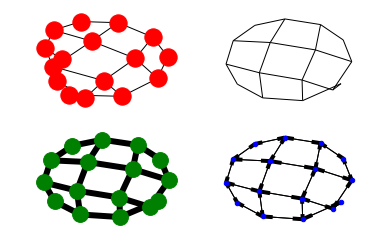

In [283]:
try:
    import matplotlib.pyplot as plt
except:
    raise

import networkx as nx

G=nx.grid_2d_graph(4,4)  #4x4 grid

pos=nx.spring_layout(G,iterations=100)

plt.subplot(221)
nx.draw(G,pos,font_size=8)

plt.subplot(222)
nx.draw(G,pos,node_color='k',node_size=0,with_labels=False)

plt.subplot(223)
nx.draw(G,pos,node_color='g',node_size=250,with_labels=False,width=6)

plt.subplot(224)
H=G.to_directed()
nx.draw(H,pos,node_color='b',node_size=20,with_labels=False)

plt.savefig("four_grids.png")
plt.show()

In [284]:
pos

{(0, 0): array([ 0.91422511,  0.2061494 ]),
 (0, 1): array([ 0.84877055,  0.12895321]),
 (0, 2): array([ 1.        ,  0.47303276]),
 (0, 3): array([ 0.93170634,  0.73673599]),
 (1, 0): array([ 0.60926531,  0.        ]),
 (1, 1): array([ 0.60466315,  0.25009148]),
 (1, 2): array([ 0.71095254,  0.61554965]),
 (1, 3): array([ 0.75176536,  0.92282587]),
 (2, 0): array([ 0.29153973,  0.03337531]),
 (2, 1): array([ 0.26504368,  0.33822867]),
 (2, 2): array([ 0.35147874,  0.70524623]),
 (2, 3): array([ 0.46804273,  0.99139384]),
 (3, 0): array([ 0.08985659,  0.19968498]),
 (3, 1): array([ 0.        ,  0.44334961]),
 (3, 2): array([ 0.0571532 ,  0.72728501]),
 (3, 3): array([ 0.22960397,  0.9136958 ])}

In [ ]:
img = img[0:img_resize[0], 0:img_resize[1]]
img = img.astype(np.int16)
dtype=None
img = np.atleast_3d(img)
n_x, n_y, n_z = img.shape
edges = _make_edges_3d(n_x, n_y, n_z)
weights = _compute_altitude_3d(edges, img)
diag = img.ravel()
n_voxels = diag.size
diag_idx = np.arange(n_voxels)
i_idx = np.hstack((edges[0], edges[1]))
j_idx = np.hstack((edges[1], edges[0]))
matrix = sparse.coo_matrix((np.hstack((weights, weights, diag)),
                          (np.hstack((i_idx, diag_idx)),
                           np.hstack((j_idx, diag_idx)))),
                          (n_voxels, n_voxels),
                          dtype=dtype)
graph = nx.from_scipy_sparse_matrix(matrix)
graph.remove_edges_from(graph.selfloop_edges())